In [ ]:
from PIL import Image
import random
import math
import time
from IPython.display import display
from IPython.display import clear_output

im_size = (240,240)
colorPallet = [(27,133,184),(90,82,85),(85,158,131),(174,90,65),(195,203,113),(249,107,75),(249,167,143),(195,155,211),(161,126,111)]
g_ang = 0

In [ ]:

def rotPnt(ang,pnt):
    rotY = getYrot(ang[1]) 
    rotX = getXrot(ang[0])
    rot_a = transformVec(rotY[0],rotY[1],rotY[2],rotX[0])
    rot_b = transformVec(rotY[0],rotY[1],rotY[2],rotX[1])
    rot_c = transformVec(rotY[0],rotY[1],rotY[2],rotX[2])
    pnt_out = transformVec(rot_a,rot_b,rot_c,pnt)
    return pnt_out

def getYrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (math.cos(ang),0.0,math.sin(ang))
    yhat = (0.0,1.0,0.0)
    zhat = (-math.sin(ang),0.0,math.cos(ang))
    return (xhat,yhat,zhat)
    
def getXrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (1.0,0.0,0.0)
    yhat = (0.0,math.cos(ang),-math.sin(ang))
    zhat = (0.0,math.sin(ang),math.cos(ang))
    return (xhat,yhat,zhat)
    
def transformVec(xhat,yhat,zhat,pnt):
    out_x = xhat[0]*pnt[0]+yhat[0]*pnt[1]+zhat[0]*pnt[2]
    out_y = xhat[1]*pnt[0]+yhat[1]*pnt[1]+zhat[1]*pnt[2]
    out_z = xhat[2]*pnt[0]+yhat[2]*pnt[1]+zhat[2]*pnt[2]
    #print((out_x,out_y,out_z))
    return (out_x,out_y,out_z)
    
def Dot_2d(a,b):
    return (a[0]*b[0] + a[1]*b[1])

def getperpendicular_clock(a):
    return (a[1],-a[0])
    
def verticeToScreen(vertice,ang,screen_size):
    pnt = rotPnt(ang,vertice)
    screenHeightWorld = 3
    pixelsPerUnitWorld = screen_size[1]/screenHeightWorld
    pixelOffset = (pnt[0]*pixelsPerUnitWorld,pnt[1]*pixelsPerUnitWorld)
    return ((screen_size[0]/2)+pixelOffset[0],(screen_size[1]/2)+pixelOffset[1])

class line_2d():
    def __init__(self,a,b):
        self.a = a
        self.b = b
        
    def isPointOnRightSide(self,pnt):
        ap = (pnt[0]-self.a[0],pnt[1]-self.a[1])
        ab_perp = getperpendicular_clock((self.b[0]-self.a[0],self.b[1]-self.a[1]))
        return (Dot_2d(ap,ab_perp) >= 0)

class triangle_2d():
    def __init__(self,a,b,c,color = (255, 255, 255) ):
        self.a = a
        self.b = b
        self.c = c
        self.ab = line_2d(a,b)
        self.bc = line_2d(b,c)
        self.ca = line_2d(c,a)
        self.color = color

    def pointInTriangle(self,pnt):        
        max_x = max(self.a[0],self.b[0],self.c[0])
        max_y = max(self.a[1],self.b[1],self.c[1])
        min_x = min(self.a[0],self.b[0],self.c[0])
        min_y = min(self.a[1],self.b[1],self.c[1])
        if pnt[0] < max_x and pnt[0]> min_x:
            if pnt[1] < max_y and pnt[1]> min_y:
                check_ab = self.ab.isPointOnRightSide(pnt)
                check_bc = self.bc.isPointOnRightSide(pnt)
                check_ca = self.ca.isPointOnRightSide(pnt)
                return (check_ab and check_bc and check_ca)
        return False

    def render(self,im):
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                if self.pointInTriangle((x,y)):
                    im.putpixel((x,y), self.color)

class triangle_3d():
    def __init__(self,a,b,c,ang,color = (255, 255, 255) ):
        self.a = a
        self.b = b
        self.c = c
        self.color = color
        self.ang = ang
        
    def trig_3dToTrig_2d(self):
        a_ = verticeToScreen(self.a,self.ang,im_size)
        b_ = verticeToScreen(self.b,self.ang,im_size)
        c_ = verticeToScreen(self.c,self.ang,im_size)
        return triangle_2d(a_,b_,c_,color=self.color)

    def render(self,im):
        self.trig_3dToTrig_2d().render(im)
        
class model():
    def __init__(self,vertices,faces,triangles):
        self.vertices = vertices
        self.faces = faces
        self.triangles = triangles
        self.ang = 0
    
    def render(self,im):
        for j,t_i in enumerate(self.triangles):
            a = self.vertices[t_i[0]]
            b = self.vertices[t_i[1]]
            c = self.vertices[t_i[2]]
            t = triangle_3d(a,b,c,self.ang,color=colorPallet[j%len(colorPallet)])
            t.render(im)

def loadObj(path):
    with open(path) as file:
        lines = [line.rstrip() for line in file]
    triangles = []
    faces = []
    vertices = []
    for line in lines:
        if line[0:2] == 'v ':
            vertice_str = line[2:].split(' ')
            v = []
            for item in vertice_str:
                v.append(float(item))
            #print(v)
            vertices.append(v)
        if line[0:2] == "f ":
            face_str = line[2:].split(' ')
            f = []
            for tstr in face_str:
                f.append(int(tstr.split('/')[0]))
            faces.append(tuple(f))
    for face in faces:
        #print(face)
        a = face[0]-1
        for i in range(len(face)-2):
            b = face[i+1]-1
            c = face[i+2]-1
            triangles.append((a,b,c))
    
    return(model(vertices,faces,triangles))




In [ ]:
im = Image.new('RGB', im_size)
tring = triangle_2d((50,50),(50,100),(100,100))
tring.render(im)
#tring.renderPoints(im)
im

In [108]:
cube = loadObj('cube.obj')
g_ang
for t in cube.triangles:
    print(t)
for v in cube.vertices:
    print(v)

(3, 6, 4)
(3, 4, 1)
(2, 3, 1)
(2, 1, 0)
(7, 2, 0)
(7, 0, 5)
(6, 7, 5)
(6, 5, 4)
(5, 0, 1)
(5, 1, 4)
(6, 3, 2)
(6, 2, 7)
[0.5, 0.5, 0.5]
[0.5, 0.5, -0.5]
[0.5, -0.5, 0.5]
[0.5, -0.5, -0.5]
[-0.5, 0.5, -0.5]
[-0.5, 0.5, 0.5]
[-0.5, -0.5, -0.5]
[-0.5, -0.5, 0.5]


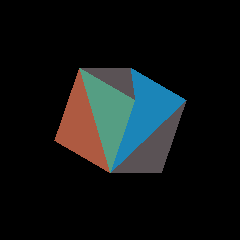

In [ ]:
j = 0
i = 0
for i in range(360):
    j += 2
    im = Image.new('RGB', im_size)
    clear_output(wait=True)
    cube.ang = (i,j)
    cube.render(im)
    display(im)